<a href="https://colab.research.google.com/github/MeiChenc/MBS-pricing-model/blob/main/MBS_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd, numpy as np
import datetime
import statsmodels.formula.api as smf

# Load the DPR file (pipe-delimited)
df = pd.read_csv('/content/PrepayData .txt', sep='|', low_memory=False)

# Strip whitespace and make machine-friendly names
df.columns = (
    df.columns
      .str.strip()
      .str.replace(' ', '_')
      .str.replace('-', '_')
)

# Identify numeric columns and force conversion
num_cols = [
    'WA_Net_Interest_Rate',
    'Cohort_Current_UPB',
    'Cohort_WA_Current_Interest_Rate',
    'Cohort_WA_Current_Remaining_Months_to_Maturity',
    'Cohort_WA_Current_Loan_Age',
    'SMM', 'Cumulative_SMM',
    'CPR', 'Cumulative_CPR'
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['date_parsed'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
df['period'] = df['date_parsed'].dt.to_period('M')

In [13]:
#--- FRED interest rate download ---

from pandas_datareader import data as web

try:
    start_year = df['date_parsed'].min().year if pd.notnull(df['date_parsed'].min()) else 2010
    end_year   = df['date_parsed'].max().year if pd.notnull(df['date_parsed'].max()) else 2025

    # Freddie Mac PMMS mortgage rates (borrower-facing)
    mr30 = web.DataReader(
        'MORTGAGE30US', 'fred',
        f'{start_year}-01-01', f'{end_year}-12-31'
    ).rename(columns={'MORTGAGE30US': 'mr30'})

    mr15 = web.DataReader(
        'MORTGAGE15US', 'fred',
        f'{start_year}-01-01', f'{end_year}-12-31'
    ).rename(columns={'MORTGAGE15US': 'mr15'})

    market_data = mr30.join(mr15, how='inner')

    # Monthly average (PMMS is weekly)
    market_monthly = market_data.resample('M').mean()

    # Convert to monthly PeriodIndex to match df['period']
    market_monthly.index = market_monthly.index.to_period('M')

    print("FRED mortgage rates (15yr / 30yr) downloaded and resampled")

except Exception as e:
    print(f"Failed to download FRED mortgage rates: {e}")
    raise

# 20yr proxy
market_monthly['mr20'] = (
    market_monthly['mr15']
    + (1.0 / 3.0) * (market_monthly['mr30'] - market_monthly['mr15'])
)


df = df.merge(
    market_monthly[['mr15', 'mr20', 'mr30']],
    left_on='period',
    right_index=True,
    how='left'
)



def assign_market_rate(row):
    sec = str(row['Type_of_Security']).lower()

    if '15' in sec:
        return row['mr15']
    elif '20' in sec:
        return row['mr20']
    elif '30' in sec:
        return row['mr30']
    else:
        # fallback：use 30yr
        return row['mr30']

df['market_rate'] = df.apply(assign_market_rate, axis=1)


/tmp/ipython-input-608478594.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_monthly = market_data.resample('M').mean()


FRED mortgage rates (15yr / 30yr) downloaded and resampled


In [3]:
# --- Feature engineering ---
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Define survival duration (loan age in months)
df['duration'] = df['Cohort_WA_Current_Loan_Age']

# Logit SMM
epsilon = 1e-6
df['smm_adj'] = df['SMM'].clip(lower=epsilon, upper=1-epsilon)
df['logit_smm'] = np.log(df['smm_adj'] / (1 - df['smm_adj']))

# Define key covariates
df['spread'] = df['Cohort_WA_Current_Interest_Rate'] - df['market_rate']
df['spread2'] = df['spread'] **2
df['spread3'] = df['spread'] **3
df['log_UPB'] = np.log(df['Cohort_Current_UPB'] + 1)
df['coupon'] = df['Cohort_WA_Current_Interest_Rate']
df['SMM'] = pd.to_numeric(df['SMM'], errors='coerce')


print(df.columns)

Index(['Type_of_Security', 'Year', 'WA_Net_Interest_Rate',
       'Cohort_Current_UPB', 'Cohort_WA_Current_Interest_Rate',
       'Cohort_WA_Current_Remaining_Months_to_Maturity',
       'Cohort_WA_Current_Loan_Age', 'Date', 'Factor_Date',
       'Principal_Reduction_Amount', 'Cumulative_Principal_Reduction_Amount',
       'Unscheduled_Principal_Reduction_Amount',
       'Cumulative_Unscheduled_Principal_Reduction_Amount', 'SMM',
       'Cumulative_SMM', 'CPR', 'Cumulative_CPR', 'date_parsed', 'period',
       'mr15', 'mr20', 'mr30', 'market_rate', 'duration', 'smm_adj',
       'logit_smm', 'spread', 'spread2', 'spread3', 'log_UPB', 'coupon'],
      dtype='object')


In [4]:
df.head()

,Type_of_Security,Year,WA_Net_Interest_Rate,Cohort_Current_UPB,Cohort_WA_Current_Interest_Rate,Cohort_WA_Current_Remaining_Months_to_Maturity,Cohort_WA_Current_Loan_Age,Date,Factor_Date,Principal_Reduction_Amount,...,mr30,market_rate,duration,smm_adj,logit_smm,spread,spread2,spread3,log_UPB,coupon
0,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190104,201902,394036.88,...,4.464,4.464,235,0.000744,-7.202725,2.92,8.5264,24.897088,20.086965,7.384
1,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190107,201902,254422.45,...,4.464,4.464,235,0.000481,-7.639162,2.92,8.5264,24.897088,20.086965,7.384
2,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190108,201902,327984.20,...,4.464,4.464,235,0.000618,-7.388404,2.92,8.5264,24.897088,20.086965,7.384
3,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190109,201902,169096.96,...,4.464,4.464,235,0.000318,-8.053141,2.92,8.5264,24.897088,20.086965,7.384
4,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190110,201902,158656.04,...,4.464,4.464,235,0.000298,-8.118119,2.92,8.5264,24.897088,20.086965,7.384


In [5]:
#check data NaN
df[['duration','spread','log_UPB','coupon']].isnull().sum()


,0
duration,0
spread,0
log_UPB,0
coupon,0


In [6]:
# Standardize x
# cols = ['spread', 'log_UPB', 'coupon']
# df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
df['log_UPB_z'] = (df['log_UPB'] - df['log_UPB'].mean()) / df['log_UPB'].std()
cols = ['spread', 'log_UPB_z', 'coupon']


df[['spread','log_UPB','coupon', 'log_UPB_z']].describe()


,spread,log_UPB,coupon,log_UPB_z
count,219924.000000,219924.000000,219924.000000,2.199240e+05
mean,0.594087,21.915420,4.221435,1.118652e-15
std,1.563193,1.435526,1.038372,1.000000e+00
min,-4.725000,20.030278,1.897000,-1.313207e+00
25%,-0.249000,20.716680,3.557000,-8.350532e-01
50%,0.828833,21.615840,4.090000,-2.086907e-01
75%,1.630000,22.797652,4.778000,6.145702e-01
max,4.563000,26.902255,7.797000,3.473873e+00


In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


df_monthly = (
    df.sort_values('Date')
      .groupby(['period', 'Type_of_Security', 'Year'])
      .last()
      .reset_index()
)

df_monthly['SMM_monthly'] = df_monthly['Cumulative_SMM']

print(df_monthly[['period', 'Date', 'Cumulative_SMM', 'SMM_monthly']].head())

    period      Date  Cumulative_SMM  SMM_monthly
0  2019-01  20190131        0.007757     0.007757
1  2019-01  20190131        0.005563     0.005563
2  2019-01  20190131        0.006575     0.006575
3  2019-01  20190131        0.004821     0.004821
4  2019-01  20190131        0.004757     0.004757


formula = "logit_smm ~ spread + I(spread**2) + I(spread**3) + log_UPB + duration"



Selected Top Security Types for Modeling: ['30yr TBA Eligible', '15yr TBA Eligible', '20yr TBA Eligible']

--> Training model for: 30yr TBA Eligible...

--> Training model for: 15yr TBA Eligible...

--> Training model for: 20yr TBA Eligible...


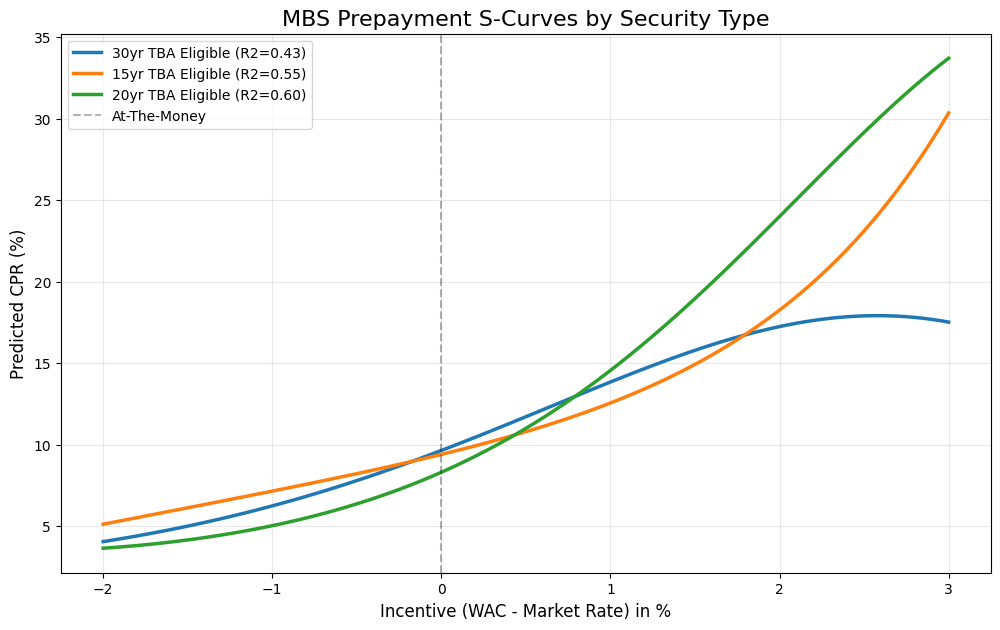


=== Model Performance Summary ===
                Type  R-squared   Obs  Coef_Spread
0  30yr TBA Eligible   0.428520  1036     0.433969
1  15yr TBA Eligible   0.546477   620     0.284445
2  20yr TBA Eligible   0.596866   584     0.579255


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define epsilon to avoid log(0) or log(1)
epsilon = 1e-6

# Clip SMM to strict (0, 1) interval
df_monthly['smm_adj'] = df_monthly['SMM_monthly'].clip(epsilon, 1-epsilon)

# Perform Logit Transformation
# Logit(p) = ln(p / (1-p))
df_monthly['logit_smm'] = np.log(df_monthly['smm_adj'] / (1 - df_monthly['smm_adj']))

# We will only model the top 3 types by data volume to ensure statistical significance
top_types = df_monthly['Type_of_Security'].value_counts().nlargest(3).index.tolist()

print(f"\nSelected Top Security Types for Modeling: {top_types}")

#Logit model training
models = {}  # Dictionary to store fitted models
model_summaries = [] # List to store metrics for comparison

# Define the regression formula
# We use cubic terms for 'spread' to capture the non-linear S-Curve shape
formula = "logit_smm ~ spread + I(spread**2) + I(spread**3) + log_UPB + duration"

plt.figure(figsize=(12, 7))

for sec_type in top_types:
    print(f"\n--> Training model for: {sec_type}...")

    # A. Subset the data
    subset = df_monthly[df_monthly['Type_of_Security'] == sec_type].copy()

    # Safety check: skip if too few data points
    if len(subset) < 50:
        print(f"    Skipping (insufficient data: {len(subset)} rows)")
        continue

  # B. Fit the OLS Model
    model = smf.ols(formula, data=subset).fit()
    models[sec_type] = model

    # Store metrics
    model_summaries.append({
        'Type': sec_type,
        'R-squared': model.rsquared,
        'Obs': int(model.nobs),
        'Coef_Spread': model.params['spread']
    })

    #Visualization S curve
    spread_range = np.linspace(-2.0, 3.0, 100)

        # Create a prediction dataframe
        # We hold other variables constant at their mean values to isolate the Spread effect
    pred_data = pd.DataFrame({
        'spread': spread_range,
        'log_UPB': subset['log_UPB'].mean(),
        'duration': subset['duration'].mean()
    })


    # Predict Logit SMM
    pred_logit = model.predict(pred_data)

    # Convert Logit back to CPR (Annualized Prepayment Rate) for easier reading
    # SMM = 1 / (1 + exp(-logit))
    pred_smm = 1 / (1 + np.exp(-pred_logit))
    pred_cpr = 1 - (1 - pred_smm)**12

    # Plot
    plt.plot(spread_range, pred_cpr * 100, label=f"{sec_type} (R2={model.rsquared:.2f})", linewidth=2.5)


plt.title("MBS Prepayment S-Curves by Security Type", fontsize=16)
plt.xlabel("Incentive (WAC - Market Rate) in %", fontsize=12)
plt.ylabel("Predicted CPR (%)", fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3, label='At-The-Money')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


summary_df = pd.DataFrame(model_summaries)
print("\n=== Model Performance Summary ===")
print(summary_df)

In [9]:
target_type = '30yr TBA Eligible'

print(f"=== OLS Regression Results for {target_type} ===")
print(models[target_type].summary())

=== OLS Regression Results for 30yr TBA Eligible ===
                            OLS Regression Results                            
Dep. Variable:              logit_smm   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     154.5
Date:                Sun, 18 Jan 2026   Prob (F-statistic):          1.78e-122
Time:                        23:03:12   Log-Likelihood:                -868.66
No. Observations:                1036   AIC:                             1749.
Df Residuals:                    1030   BIC:                             1779.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

1. R-squared (0.429): The model explains 42.9% of the variation in the prepayment rate (Logit SMM). In behavioral finance and prepayment modeling, an R-squared between 0.20 and 0.50 is considered strong. It indicates that your selected variables (Spread, Age, Size) are effective predictors.F-statistic &
2. Prob (F): The Probability ($1.78e^{-122}$) is effectively zero. This confirms that the model is statistically significant globally; the variables jointly explain the prepayment behavior better than a random guess.
3. Coefficient (+0.4340): The positive coefficient for spread is the most important finding. It confirms that as the incentive increases (Market Rates fall), prepayment rates rise.
4. Significance ($t = 23.255, P < 0.001$): This variable has the highest t-statistic, making it the dominant driver of the model. This aligns perfectly with economic theory.
5. Non-Linearity (S-Curve): The coefficients for spread^2 and spread^3 are both statistically significant ($P < 0.001$). This proves that the relationship is not linear. The model successfully captures the "S-Curve" effect, where prepayments accelerate non-linearly as the option becomes "in-the-money."
6. Duration (Loan Age):

    Coefficient (-0.0027): The coefficient is negative and significant.

    Interpretation: This implies that, holding other factors constant, older loans in this specific dataset tend to prepay slower.

    Note: While standard PSA curves usually slope upward (seasoning), a negative coefficient here likely captures the "Burnout Effect". The remaining borrowers in older pools are likely those who cannot refinance (due to credit or LTV issues), leading to lower SMMs despite the loan's age.
7. log_UPB (Pool Size):

    P-value (0.061): This is slightly above the standard 0.05 threshold (marginal significance).

    Interpretation: The size of the pool (UPB) is not a strong predictor of prepayment speed for this specific cohort compared to Spread and Duration.
8. Condition Number (2.92e+03): The number is high, suggesting Multicollinearity.

    Reason: This is expected because we included polynomial terms (spread, spread^2, spread^3) which are naturally correlated. In this specific context (polynomial regression for curve fitting), this is acceptable and does not invalidate the predictive power of the model.

###"The OLS regression for the 30-year cohort yields a robust R-squared of 42.9%. The results statistically confirm the Refinancing Incentive (Spread) as the primary driver of prepayments ($t=23.3$), with significant polynomial terms confirming the presence of the Prepayment S-Curve.Additionally, the negative coefficient on Duration suggests that the model has captured the Burnout Effect, where older loans exhibit reduced prepayment speeds as the pool of eligible borrowers depletes."

Analyzing Cohort: 30yr TBA Eligible
Current Spread: 0.40%
Prices:
Price (Rates -50bps):    $103.64
Price (Base Case):       $101.79
Price (Rates +50bps):    $99.50
Duration:
Effective Duration:      4.06
Interpretation: A duration lower than typical bonds implies Negative Convexity due to prepayments.


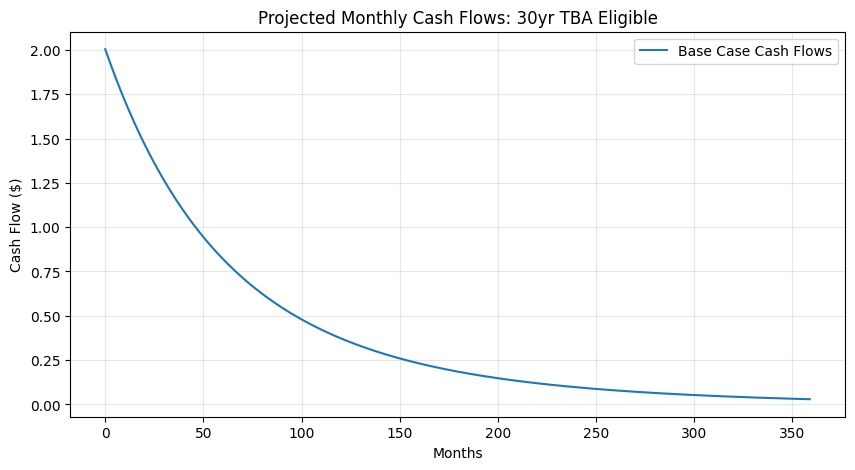

In [16]:
# Pricing Engine & Risk Analysis (Effective Duration)
import numpy as np
import pandas as pd

def to_decimal_rate(x):
    """Convert percent-point rate (e.g., 6.5) or decimal (0.065) into decimal."""
    x = float(x)
    return x / 100.0 if x > 1.0 else x

def mortgage_payment(balance, wac_dec, remaining_term_months):
    """Level-payment mortgage payment (monthly)."""
    r = wac_dec / 12.0
    if remaining_term_months <= 0:
        return balance
    if abs(r) < 1e-12:
        return balance / remaining_term_months
    return balance * r / (1.0 - (1.0 + r) ** (-remaining_term_months))

def price_mbs_simulation(
    model,
    initial_state,
    shock_bps=0,
    oas_bps=0,
    term_months=360,
    face=100.0,
    wac_col="Cohort_WA_Current_Interest_Rate",
    mr_col="market_rate",
    age_col="duration",
    upb_col="CurrentUPB",
    # feature columns expected by the model (adjust if your training used different names)
    spread_col="spread",
    spread2_col="spread2",
    spread3_col="spread3",
    logupb_col="log_upb",
):
    """
    Simulates path-dependent MBS cashflows using a logit-based SMM model.

    Parameters
    - model: fitted statsmodels object (predict returns logit-scale linear predictor)
    - initial_state: Series/row from df_monthly for the cohort
    - shock_bps: market rate shock in basis points (+50 / -50)
    - oas_bps: constant OAS added to discounting in basis points
    """

    # Work on a 1-row DataFrame state (for statsmodels predict)
    state = pd.DataFrame([initial_state]).copy()

    # --- Pull rates from data (MOST accurate within your setup) ---
    wac_dec = to_decimal_rate(state[wac_col].iloc[0])      # coupon
    mr_dec  = to_decimal_rate(state[mr_col].iloc[0])       # maturity-matched market rate (already 15/20/30 aware)

    shock_dec = shock_bps / 10000.0
    oas_dec   = oas_bps / 10000.0

    # Discount curve approximation (flat): market rate + OAS + shock
    disc_dec = mr_dec + oas_dec + shock_dec
    r_month = disc_dec / 12.0

    # --- Balance scaling ---
    # Use face-scale for cashflow; if you want to preserve pool UPB scale in features,
    # you can anchor log_upb to original UPB and update proportionally.
    balance = float(face)

    cashflows = []

    # Initialize/ensure key fields exist
    if age_col not in state.columns:
        state[age_col] = 0
    if upb_col not in state.columns:
        # if no UPB in row, default to face (still coherent)
        state[upb_col] = balance

    # Keep WAC and MarketRate in percent-points too (for spread features), if your model trained in percent-points
    wac_pct = float(state[wac_col].iloc[0])  # could be 6.25 or 0.0625; handle both
    mr_pct  = float(state[mr_col].iloc[0])

    # Normalize percent-points representation for spread features:
    # If stored as decimal in data, convert to percent points.
    if wac_pct <= 1.0: wac_pct *= 100.0
    if mr_pct  <= 1.0: mr_pct  *= 100.0

    shock_pct = shock_bps / 100.0  # 50 bps -> 0.50 percentage points

    for t in range(1, term_months + 1):
        # 1) update age
        state[age_col] = float(state[age_col].iloc[0]) + 1.0

        # 2) update spread features coherently with shocked market rate
        spread_pct = wac_pct - (mr_pct + shock_pct)
        state[spread_col]  = spread_pct
        state[spread2_col] = spread_pct ** 2
        state[spread3_col] = spread_pct ** 3

        # 3) update UPB feature (face-scale; robust and keeps dynamics)
        state[logupb_col] = np.log(max(balance, 1e-6))

        # 4) predict SMM (logit-scale -> probability)
        pred_logit = float(model.predict(state).iloc[0])
        smm = 1.0 / (1.0 + np.exp(-pred_logit))
        smm = float(np.clip(smm, 0.0, 0.6))  # optional cap to avoid numerical blow-ups

        # 5) cashflow mechanics with scheduled amortization + prepayment
        remaining = term_months - t + 1
        pmt = mortgage_payment(balance, wac_dec, remaining)
        interest = balance * wac_dec / 12.0
        sched_principal = max(pmt - interest, 0.0)

        # Apply prepayment on remaining balance after scheduled principal (standard convention)
        bal_after_sched = max(balance - sched_principal, 0.0)
        prepay_principal = smm * bal_after_sched

        total_principal = min(balance, sched_principal + prepay_principal)
        cf = interest + total_principal

        cashflows.append(cf)
        balance -= total_principal

        if balance <= 1e-6:
            break

    pv = sum(cf / ((1.0 + r_month) ** (i + 1)) for i, cf in enumerate(cashflows))
    return pv, cashflows


# --- Execute Analysis for the Main Type ---
target_type = '30yr TBA Eligible'

if target_type in models:
    # Select the most recent record for this security type
    latest_cohort = df_monthly[df_monthly['Type_of_Security'] == target_type].iloc[-1]

    print(f"Analyzing Cohort: {target_type}")
    print(f"Current Spread: {latest_cohort['spread']:.2f}%")

    # Calculate Prices under different scenarios
    # Shock units: 0.50 means 50 basis points
    p_base, cf_base = price_mbs_simulation(models[target_type], latest_cohort, shock_bps=0,   oas_bps=0)
    p_up, _         = price_mbs_simulation(models[target_type], latest_cohort, shock_bps=+50, oas_bps=0)
    p_down, _       = price_mbs_simulation(models[target_type], latest_cohort, shock_bps=-50, oas_bps=0)

    dy = 50/10000
    eff_duration = (p_down - p_up) / (2 * p_base * dy)


    print('Prices:')
    print(f"Price (Rates -50bps):    ${p_down:.2f}")
    print(f"Price (Base Case):       ${p_base:.2f}")
    print(f"Price (Rates +50bps):    ${p_up:.2f}")

    print('Duration:')
    print(f"Effective Duration:      {eff_duration:.2f}")
    print("Interpretation: A duration lower than typical bonds implies Negative Convexity due to prepayments.")

    # Plot Cash Flows
    plt.figure(figsize=(10, 5))
    plt.plot(cf_base, label='Base Case Cash Flows')
    plt.title(f"Projected Monthly Cash Flows: {target_type}")
    plt.xlabel("Months")
    plt.ylabel("Cash Flow ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Model for {target_type} not found.")

Simulating 21 interest scenarios...


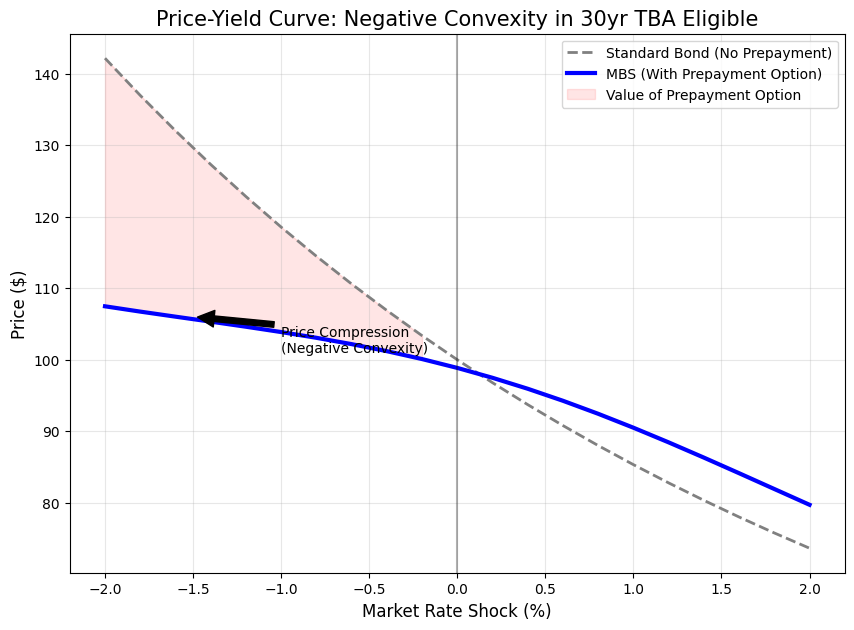

In [11]:
#Price-Yield curve (Negative convexity)
def price_vanilla_bond(initial_state, market_rate_shock=0.0):
    """
    Compute 'Non-callable bond' price
    Assumption: SMM = 0
    """
    balance = 100.0
    wac = 0.045 # Assume coupon: 4.5%
    discount_rate = 0.045 + (market_rate_shock / 100)

    cashflows = []
    r_month = discount_rate / 12
    coupon_month = wac / 12

    # Assume SMM=0!
    for t in range(1, 361):
        interest = balance * coupon_month
        principal = 0 # No prepayment


        if t == 360:
            principal = balance

        cashflows.append(interest + principal)

    # 折現
    pv = sum([cf / ((1 + r_month) ** (i+1)) for i, cf in enumerate(cashflows)])
    return pv
#Scenario
# 30yr Pool
target_type = '30yr TBA Eligible'
if target_type in models:
    latest_cohort = df_monthly[df_monthly['Type_of_Security'] == target_type].iloc[-1]

    # interest rate range: -2% (-200bps) to +2% (+200bps)
    shocks = np.linspace(-2.0, 2.0, 21)

    prices_mbs = []
    prices_vanilla = []

    print(f"Simulating {len(shocks)} interest scenarios...")

    for shock in shocks:
# MBS pricing
        p_mbs, _ = price_mbs_simulation(models[target_type], latest_cohort, market_rate_shock=shock)
        prices_mbs.append(p_mbs)

# Normal bond priciing
        p_vanilla = price_vanilla_bond(latest_cohort, market_rate_shock=shock)
        prices_vanilla.append(p_vanilla)


    plt.figure(figsize=(10, 7))
    plt.plot(shocks, prices_vanilla, color='grey', linestyle='--', linewidth=2, label='Standard Bond (No Prepayment)')
    plt.plot(shocks, prices_mbs, color='blue', linewidth=3, label='MBS (With Prepayment Option)')
    plt.fill_between(shocks, prices_mbs, prices_vanilla, where=(shocks < 0), color='red', alpha=0.1, label='Value of Prepayment Option')


    plt.title(f"Price-Yield Curve: Negative Convexity in {target_type}", fontsize=15)
    plt.xlabel("Market Rate Shock (%)", fontsize=12)
    plt.ylabel("Price ($)", fontsize=12)
    plt.axvline(x=0, color='black', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.annotate('Price Compression\n(Negative Convexity)', xy=(-1.5, prices_mbs[2]), xytext=(-1.0, prices_mbs[2]-5),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()